### **DEEP LEARNING MODEL : CNN into RealWaste data set**

## 1-Download and data extraction

In this work we  will explore  another image data further, and then we will follow the same steps.


In [1]:
!wget https://archive.ics.uci.edu/static/public/908/realwaste.zip

--2024-03-10 15:47:59--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [   <=>              ] 656.65M  4.41MB/s    in 2m 14s  

2024-03-10 15:50:14 (4.91 MB/s) - ‘realwaste.zip’ saved [688545323]



In [ ]:
!unzip realwaste.zip

In [3]:
ls

realwaste-main/  realwaste.zip  sample_data/


##2-Move data from images to images/train or images/test and Split the data


In this part we split and prepare it for the model

In [4]:
import shutil
import json
from pathlib import Path
import os

def split_dataset(root_image_path):
    """Takes in the path for image data directory and creates train/test dirs of images"""
    data_paths = {
        'train': root_image_path / 'train',
        'test': root_image_path / 'test'
    }

    # Make train/test dirs
    for data_type, data_path in data_paths.items():
        os.makedirs(data_path, exist_ok=True)

        # Iterate through the categories in your data
        for category in ['Cardboard', 'Glass', 'Miscellaneous Trash', 'Plastic', 'Vegetation',
                         'Food Organics', 'Metal', 'Paper', 'Textile Trash']:
            category_path = data_path / category
            os.makedirs(category_path, exist_ok=True)

            # Move images from images to train (or test)
            images_path = root_image_path / category
            image_files = os.listdir(images_path)

            # Split the images into train and test based on your requirements
            num_train = int(0.8 * len(image_files))  # 80% for training, adjust as needed

            if data_type == 'train':
                selected_images = image_files[:num_train]
            else:
                selected_images = image_files[num_train:]

            for image_file in selected_images:
                image_path = images_path / image_file
                shutil.move(image_path, category_path / image_file)


In [5]:
from pathlib import Path

download_dir = Path('/content/realwaste-main')

split_dataset(download_dir/'RealWaste')

##3-Image augmentations

In this segment, we implement augmentations aimed at enriching the diversity of our training dataset through various techniques, such as random rotation, adjustments in brightness levels, shifts in object positions, and flipping images horizontally or vertically. These augmentations not only expand the dataset's variability but also enhance the model's robustness and generalization capabilities.

In [6]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Image augmentations
example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [8]:
import os

class_subset = sorted(os.listdir(download_dir/'RealWaste'))[:9]

In [9]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'RealWaste/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'RealWaste/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 3231 images belonging to 9 classes.
Found 24 images belonging to 9 classes.


##4-CNN model

Here we are going to customize the CNN model

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [ ]:
#pip install livelossplot

##5-Training of the model

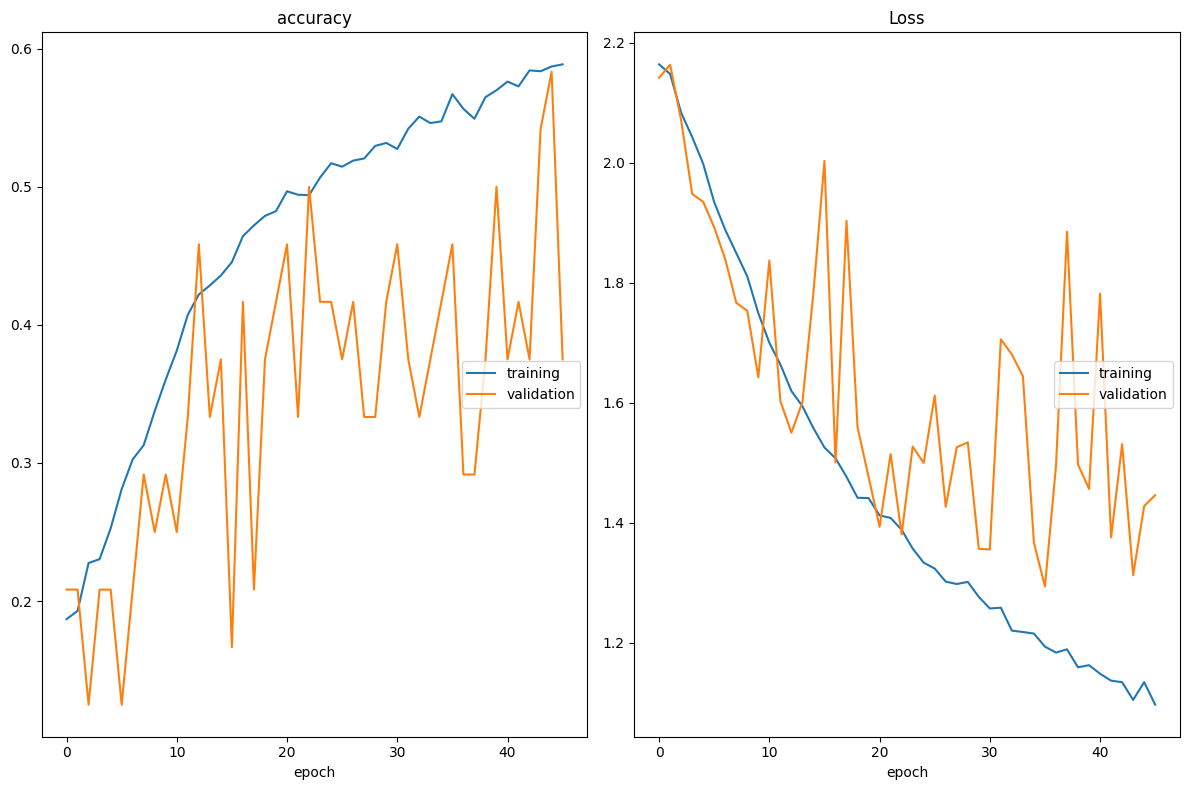

accuracy
	training         	 (min:    0.187, max:    0.589, cur:    0.589)
	validation       	 (min:    0.125, max:    0.583, cur:    0.375)
Loss
	training         	 (min:    1.096, max:    2.164, cur:    1.096)
	validation       	 (min:    1.293, max:    2.163, cur:    1.446)


NameError: name 'torch' is not defined

In [12]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras


# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(1, traingen.samples // BATCH_SIZE) if traingen.samples > 0 else 1
val_steps = max(1, validgen.samples // BATCH_SIZE) if validgen.samples > 0 else 1

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
history = model.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

# Define filename and path for model
model_filename = "model_r.pth"
model_path = os.path.join(os.getcwd(), model_filename)
# Serialize the model to disk
torch.save(model, model_path)

When we observe, the two curve we could have an huge idea about the performance of the model.

We could see that the model perform well in the training dataset but very but on the validation data set. Both the curves of accuracy and the loss function show that the model is not performing well,it exhib a case of underfitting. To deal with this problem with must add the quantity of the data and and ajust same parameters.

##6-Evaluating Our Network

In [16]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'RealWaste/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)

Found 193 images belonging to 9 classes.


In [18]:
# Load the weights
model.load_weights('img_model.weights.best.hdf5')

# Predict classes
predicted_probs = model.predict(testgen)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Get class indices
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

# Get true classes
true_classes = testgen.classes


193/193 [==============================] - 3s 8ms/step


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

#7-Result of the predictions

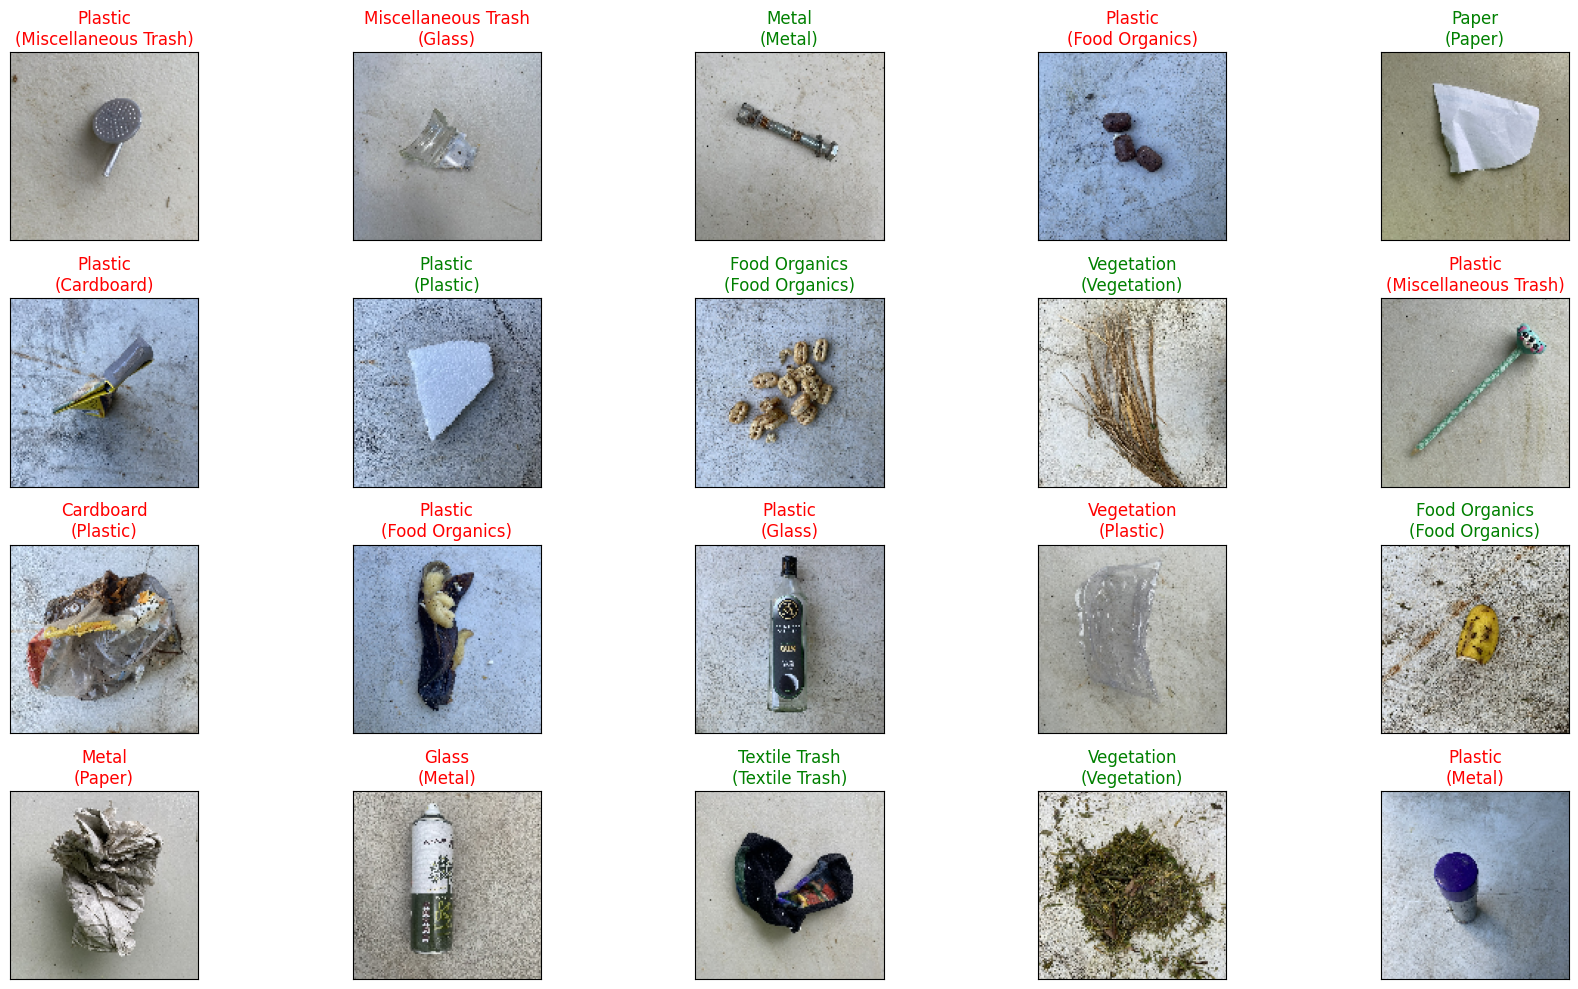

In [20]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

When we see the result of this predictions over 20 images, the model classified correctly 8 images and misclasssified 12 images, that show that the model is not very good fit for the prediction and may need some ajustment to perform well.

##8-Display the prediction

In [21]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 45.60%


,Precision,Recall,F-Score,Support
Vegetation,0.586207,0.944444,0.723404,18.0
Cardboard,0.484848,0.842105,0.615385,19.0
Glass,0.500000,0.529412,0.514286,17.0
Metal,0.411765,0.437500,0.424242,32.0
Plastic,0.377778,0.459459,0.414634,37.0
Paper,0.666667,0.300000,0.413793,20.0
Food Organics,0.428571,0.352941,0.387097,17.0
Miscellaneous Trash,0.222222,0.100000,0.137931,20.0
Textile Trash,0.500000,0.076923,0.133333,13.0


This result show the differents metrics of the model, the level of precison uoon each classes, the recall of the model and the F-score.  And we can seee that the level of precison are almost less than 0.5 which is the probality to a images to belong to the given class.

###Conclusion

Same as the previous one we realised that the model is not performing well such things could be explain by the number of data. Moreever,tuning same parameters of the model and by addressing same challengens related to the imballance data may lead to a good accuracy.